# Concessão de Crédito - Estudo de Caso - Neurotech

# Entendimento da base e análise exploratória dos dados

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.gz', compression='gzip')
test = pd.read_csv('test.gz', compression='gzip')
print("Formato dataset: ", train.shape)
print(train.info())
train.head(5)

Formato dataset:  (120750, 151)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120750 entries, 0 to 120749
Columns: 151 entries, REF_DATE to ID
dtypes: float64(34), int64(3), object(114)
memory usage: 139.1+ MB
None


,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,...,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,ID
0,2017-06-01 00:00:00+00:00,0,M,34.137,NaN,RO,-8.808779,-63.878470,D,E,...,2680.289259,D,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,181755
1,2017-08-18 00:00:00+00:00,0,M,40.447,NaN,PB,-7.146537,-34.926080,E,E,...,1777.725469,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,287633
2,2017-06-30 00:00:00+00:00,0,F,33.515,NaN,RS,-27.900178,-53.314035,NaN,E,...,1695.494979,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,88015
3,2017-08-05 00:00:00+00:00,1,F,25.797,NaN,BA,-12.948874,-38.451863,E,E,...,1399.037809,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,122576
4,2017-07-29 00:00:00+00:00,0,F,54.074,NaN,RS,-30.051810,-51.213277,B,E,...,7868.793296,C,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1,1272


Conferindo se as variáveis de treino e teste são as mesmas

In [3]:
print(set(train.columns).symmetric_difference(set(test.columns)))
print(set(train.columns) == (set(test.columns)))
print(set(train['ID']).intersection(set(test['ID'])))

set()
True
set()


Vou juntar os dados de treino e teste para fazer algumas etapas do pre-processamento, enquanto guardo os IDs de cada para uso futuro.

In [4]:
test_ids = test['ID'].to_list()

In [5]:
data = pd.concat([train, test], axis=0)
data.head()

,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,...,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,ID
0,2017-06-01 00:00:00+00:00,0,M,34.137,NaN,RO,-8.808779,-63.878470,D,E,...,2680.289259,D,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,181755
1,2017-08-18 00:00:00+00:00,0,M,40.447,NaN,PB,-7.146537,-34.926080,E,E,...,1777.725469,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,287633
2,2017-06-30 00:00:00+00:00,0,F,33.515,NaN,RS,-27.900178,-53.314035,NaN,E,...,1695.494979,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,88015
3,2017-08-05 00:00:00+00:00,1,F,25.797,NaN,BA,-12.948874,-38.451863,E,E,...,1399.037809,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,122576
4,2017-07-29 00:00:00+00:00,0,F,54.074,NaN,RS,-30.051810,-51.213277,B,E,...,7868.793296,C,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1,1272


## Handling Missing Values

Algumas colunas parecem apresentar muitos valores NaN. Vamos analisar a porcentagem de valores NaN em cada coluna.

In [6]:
def drop_missing_data_columns(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    columns_drop = missing_data.index[missing_data['Percent'] >= 0.20]
    
    data.drop(columns=columns_drop, inplace=True)  # Drop columns inplace

    print("Columns with more than 20% NaN values have been removed.")
    print("Number of columns removed: ", len(columns_drop))
    print("Shape of the dataset after dropping columns: ", data.shape)

    return data

In [7]:
data = drop_missing_data_columns(data)

Columns with more than 20% NaN values have been removed.
Number of columns removed:  38
Shape of the dataset after dropping columns:  (172501, 113)


In [8]:
def simple_imputation(data, imputation):
    data_copy = data.copy()  
    
    if imputation:  
        for col in data_copy.columns:
            if data_copy[col].dtype == 'object':
                data_copy[col].fillna(data_copy[col].mode()[0], inplace=True)
            else:
                data_copy[col].fillna(data_copy[col].median(), inplace=True)
    else:
        data_copy.dropna(inplace=True)
        print("Shape of the dataset after removing rows with NaN values:", data_copy.shape)
    return data_copy

In [9]:
# Dados com imputação simples
data_imputed = simple_imputation(data, imputation=True)
data_drop = simple_imputation(data, imputation=False)

Shape of the dataset after removing rows with NaN values: (129606, 113)


In [10]:
data.shape

(172501, 113)

## Checando dados duplicados, noisy data

In [11]:
def check_noisy(data):
    duplicadas = data.duplicated()
    print('Dados duplicados: ', duplicadas.unique())
    print('NaN :', data['TARGET'].isna().sum())
    print('Target unique values: ', data['TARGET'].unique())
    
    data_noisy = data.drop(columns=['ID', 'REF_DATE'])
    data['unique_target'] = data.groupby(data_noisy.columns.to_list())['TARGET'].transform('nunique')
    print('Unique combinations of the columns in data_noisy with distinct target values: ', data['unique_target'].unique())
    noisy_data = data[data['unique_target'] > 1].drop('unique_target', axis=1)
    print(noisy_data.shape)
    data.drop(columns=['unique_target'], inplace=True)

In [12]:
check_noisy(data_imputed)

Dados duplicados:  [False]
NaN : 0
Target unique values:  [0 1]
Unique combinations of the columns in data_noisy with distinct target values:  [1]
(0, 113)


## Balanceamento da váriavel 'TARGET'

In [13]:
def percentage_target(data):

    bad = data['TARGET'].value_counts()[1]
    good = data['TARGET'].value_counts()[0]
    total = data['TARGET'].value_counts().sum() 
    percent_good = (good/total)*100
    percent_bad = (bad/total)*100

    print('% Bons Pagadores: ', round(percent_good, 2),'%')
    print('% Maus Pagadores: ', round(percent_bad, 2),'%')
    return percent_good, percent_bad

def plot_class_imbalance(percent_bad, percent_good):
    import plotly.graph_objects as go

    fig = go.Figure(go.Bar(x=[0, 1], y=[percent_good, percent_bad],
                showlegend=False,
                marker=dict(color='rgba(155, 190, 250, 0.7)')
                ))
    fig.add_annotation(
        text='Dados de treino',
        xref='paper', yref='paper',
        x=-0.23, y=1.1,  
        showarrow=False,
        font=dict(size=12, color='rgba(100, 159, 237, 1)'))

    # Update layout
    fig.update_layout(title_text='% DE PAGADORES',
                    plot_bgcolor='rgba(0, 0, 0, 0)',
                    yaxis_ticksuffix="%",
                    coloraxis_colorbar_ticksuffix="m",
                    yaxis_showticksuffix="all"
                    )
    fig.update_yaxes(ticks="outside", tickwidth=1, tickcolor='rgba(169, 169, 169, 1)', ticklen=10)
    fig.update_yaxes(showline=True, linewidth=1, linecolor='rgba(169, 169, 169, 1)')
    fig.update_layout(xaxis=dict(tickvals=[0, 1], ticktext=['Bons (0)', 'Maus (1)'])
                    )
    fig.layout.update({'width' : 400, 'height': 500})

    fig.show()

In [14]:
percent_good, percent_bad = percentage_target(data_imputed)
plot_class_imbalance(percent_bad, percent_good)

% Bons Pagadores:  75.5 %
% Maus Pagadores:  24.5 %


Parece que temos um desbalanço de classe que deverá ser tratado quando formos treinar do nosso modelo.

## Tipos de variáveis no dataset de treino

In [15]:
data_imputed.dtypes.value_counts()

object     100
float64     10
int64        3
Name: count, dtype: int64

Temos 100 variáveis com entradas do tipo object, e apenas 13 variáveis de tipo numérico. Para fins de uma primeira análise vou separar em dois dataframes as variáveis numéricas e as variáveis não numéricas.

In [16]:
def split_num_cat(data):
    columns = data.dtypes != 'object'
    columns_to_keep = data.columns[columns]
    data_num = data[columns_to_keep]
    data_cat = data.drop(columns_to_keep, axis=1)
    return data_num, data_cat

In [17]:
data_imputed = data_imputed[data_imputed['VAR2'] != 'I']

In [18]:
data_num, data_cat = split_num_cat(data_imputed)

# Pré-processamento das variáveis

## Tratamento das variáveis categoricas

In [19]:
data_cat['MONTH'] = pd.to_datetime(data_cat['REF_DATE']).dt.strftime('%B')

As colunas REF_DATE, VAR48 e VAR49 não parecem adicionar informação no nosso modelo 

In [20]:
data_cat['VAR148'].value_counts()

VAR148
EMAIL INEXISTENTE                                         74883
EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INEXISTENTE    72497
OPERACAO REALIZADA COM SUCESSO                            13635
NOME INEXISTENTE#@#EMAIL INEXISTENTE                      10183
CEP INEXISTENTE#@#EMAIL INEXISTENTE                         674
NOME INEXISTENTE                                            614
CEP INEXISTENTE                                               9
NOME INEXISTENTE#@#CEP INEXISTENTE                            5
Name: count, dtype: int64

In [21]:
data_cat['VAR149'].value_counts()

VAR149
2.6.1    172500
Name: count, dtype: int64

Vou remover as duas

In [22]:
data_cat.drop(columns=['REF_DATE', 'VAR148', 'VAR149'], inplace=True)

## Enconding Categorical Features
Nesta sessão vamos: 
1) Ver quais são as categorias existentes em todo o dataset e se são ordinais ou nominais
2) Fazer o encoding das variáveis categóricas


Vou usar a função OrdinalEnconder() do sklearn para codificar numericamente as categorias que apresentam uma hierarquia.

Para as escalas que não apresentam ordem vamos usar binary enconding. Como temos apenas duas variáveis, podemos usar também o OrdinalEncoder do sklearn para dar valores numéricos 0 ou 1 para as variáveis categóricas binárias.

Vou usar one-hot encoding nas variáveis categóricas que apresentam escala de meses, estados e classificação (A, B, C, D, E), por não saber se estas últimas são ordinais ou não, já que não tenho o contexto das variáveis.

In [23]:
# get the unique categories for each column
unique_categories = {column: sorted(data_cat[column].unique()) for column in data_cat.columns}
unique_cats = set(tuple(x) for x in unique_categories.values())
unique_cats

{('A', 'B', 'C', 'D', 'E'),
 ('AC',
  'AL',
  'AM',
  'AP',
  'BA',
  'CE',
  'DF',
  'ES',
  'GO',
  'MA',
  'MG',
  'MS',
  'MT',
  'PA',
  'PB',
  'PE',
  'PI',
  'PR',
  'RJ',
  'RN',
  'RO',
  'RR',
  'RS',
  'SC',
  'SE',
  'SP',
  'TO'),
 ('ALTA', 'ALTISSIMA', 'BAIXA', 'BAIXISSIMA', 'MEDIA'),
 ('ALTA', 'ALTISSIMA', 'BAIXISSIMA'),
 ('ALTA', 'ALTISSIMA', 'BAIXISSIMA', 'MEDIA'),
 ('ALTISSIMA', 'BAIXISSIMA'),
 ('April', 'August', 'February', 'January', 'July', 'June', 'March', 'May'),
 ('F', 'M'),
 ('LONGE', 'MEDIO', 'MUITO LONGE', 'MUITO PROXIMO', 'PROXIMO'),
 ('LONGE', 'MEDIO', 'MUITO LONGE', 'PROXIMO'),
 ('MUITO LONGE', 'PROXIMO'),
 ('N', 'S')}

In [24]:
data_cat['VAR2'].value_counts()

VAR2
F    106945
M     65555
Name: count, dtype: int64

Vou deletar a entrada que apresenta 'I' na VAR2

Eu normalizo todas as variáveis com entradas de distância e frequência para as escalas de categorias:

('LONGE', 'MEDIO', 'MUITO LONGE', 'MUITO PROXIMO', 'PROXIMO')

('ALTA', 'ALTISSIMA', 'BAIXA', 'BAIXISSIMA', 'MEDIA')

In [25]:
def preprocessing_cat(dataframe):
    from sklearn.preprocessing import OrdinalEncoder
    dataframe_copy = dataframe.copy()  

    # categorias existentes
    categoriais_ordinais = [('ALTA', 'ALTISSIMA', 'BAIXA', 'BAIXISSIMA', 'MEDIA'), 
                        ('LONGE', 'MEDIO', 'MUITO LONGE', 'MUITO PROXIMO', 'PROXIMO')]
    categorias_nominais = [('N', 'S'), ('F', 'M')]
    states = list(dataframe_copy['VAR5'].unique())
    months = list(dataframe_copy['MONTH'].unique())
    categoria_one_hot = [('A', 'B', 'C', 'D', 'E'), states, months]
    # inicializando
    ordinal_columns0 = []
    ordinal_columns1 = []
    nominal_columns = []
    ohe_columns = []
    # agrupando variáveis dos mesmos grupos de categorias
    for col in dataframe_copy:
        if set(tuple(unique_categories[col])).issubset(categoriais_ordinais[0]):
            ordinal_columns0.append(col)
        elif set(tuple(unique_categories[col])).issubset(categoriais_ordinais[1]):
            ordinal_columns1.append(col)
        elif any(set(tuple(unique_categories[col])).issubset(x) for x in categorias_nominais):
            nominal_columns.append(col)
        elif any(set(tuple(unique_categories[col])).issubset(x) for x in categoria_one_hot):
            ohe_columns.append(col)
    
    encoder1 = OrdinalEncoder(categories=[['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']]*len(ordinal_columns0)).set_output(transform="pandas")
    encoded1 = encoder1.fit_transform(dataframe_copy[ordinal_columns0])
    encoder2 = OrdinalEncoder(categories=[('MUITO LONGE','LONGE', 'MEDIO', 'PROXIMO', 'MUITO PROXIMO')]*len(ordinal_columns1)).set_output(transform="pandas")
    encoded2 = encoder2.fit_transform(dataframe_copy[ordinal_columns1])
    encoder = OrdinalEncoder().set_output(transform="pandas")
    nominal_encoded = encoder.fit_transform(dataframe_copy[nominal_columns])
    data_ohe = dataframe_copy[ohe_columns]
    ohe_encoded = pd.get_dummies(data_ohe)

    dataframe_encoded = pd.concat([encoded1, encoded2, nominal_encoded, ohe_encoded], axis=1)
    
    return dataframe_encoded

In [26]:
data_cat_encoded = preprocessing_cat(data_cat)

## Correlações

## Correlação Variáveis Numéricas x Target

In [27]:
data_num.corr()

,TARGET,IDADE,VAR6,VAR7,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR141,VAR147,ID
TARGET,1.000000,-0.106138,0.029698,0.030894,-0.035071,-0.077034,-0.037316,-0.050562,-0.017345,-0.009068,-0.015161,0.025920,-0.001583
IDADE,-0.106138,1.000000,-0.064221,0.006996,0.052485,0.404054,0.007622,-0.009956,0.159878,0.092104,0.243246,-0.082952,-0.000827
VAR6,0.029698,-0.064221,1.000000,0.177161,-0.185727,0.056422,-0.137198,0.041487,-0.007383,-0.035748,-0.085721,0.086003,0.002588
VAR7,0.030894,0.006996,0.177161,1.000000,-0.025117,0.014193,0.080335,0.095734,0.037143,0.055708,-0.053163,0.059149,-0.001676
VAR24,-0.035071,0.052485,-0.185727,-0.025117,1.000000,-0.205543,0.036843,0.044916,-0.006858,0.020512,0.122262,-0.220059,0.001004
VAR39,-0.077034,0.404054,0.056422,0.014193,-0.205543,1.000000,0.098010,0.119399,0.130707,0.090401,0.251693,-0.021559,0.001431
VAR40,-0.037316,0.007622,-0.137198,0.080335,0.036843,0.098010,1.000000,0.629167,0.035844,0.010951,0.029022,0.035793,-0.001784
VAR41,-0.050562,-0.009956,0.041487,0.095734,0.044916,0.119399,0.629167,1.000000,0.032546,0.008785,-0.012569,0.077054,-0.000618
VAR42,-0.017345,0.159878,-0.007383,0.037143,-0.006858,0.130707,0.035844,0.032546,1.000000,0.350947,0.058760,0.004072,0.000927
VAR47,-0.009068,0.092104,-0.035748,0.055708,0.020512,0.090401,0.010951,0.008785,0.350947,1.000000,0.062424,0.002804,-0.001553


In [28]:
correlations = data_num.corr()['TARGET'].sort_values()

print('Correlações mais positivas:\n', correlations.tail(5))
print('\nCorrelações mais negativas:\n', correlations.head(5))

Correlações mais positivas:
 ID       -0.001583
VAR147    0.025920
VAR6      0.029698
VAR7      0.030894
TARGET    1.000000
Name: TARGET, dtype: float64

Correlações mais negativas:
 IDADE   -0.106138
VAR39   -0.077034
VAR41   -0.050562
VAR40   -0.037316
VAR24   -0.035071
Name: TARGET, dtype: float64


In [29]:
data_num.describe()

,TARGET,IDADE,VAR6,VAR7,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR141,VAR147,ID
count,172500.00000,172500.000000,172500.000000,172500.000000,172500.000000,172500.000000,172500.000000,172500.000000,172500.000000,172500.000000,172500.000000,172500.000000,172500.000000
mean,0.24502,41.854059,-14.371637,-45.914288,0.071194,0.460960,0.531064,0.629206,0.503850,0.257033,1851.234592,101.841913,165340.832742
std,0.43010,14.327145,8.880359,7.425464,0.126196,0.144059,0.114756,0.220372,0.065590,0.407066,878.355771,0.539615,95542.882383
min,0.00000,18.014000,-33.521563,-72.900276,0.000000,0.049309,0.208688,0.000000,0.006658,0.000000,0.000000,100.000000,2.000000
25%,0.00000,31.268000,-22.788501,-49.638536,0.000000,0.363543,0.449550,0.442538,0.469239,0.000000,1513.227400,102.000000,82681.000000
50%,0.00000,39.855000,-13.009675,-46.564254,0.034000,0.462267,0.510118,0.542357,0.496036,0.003000,1627.157652,102.000000,165256.000000
75%,0.00000,51.066500,-6.515630,-39.072056,0.069000,0.557800,0.579877,0.892648,0.515328,0.426000,1815.143850,102.000000,248307.250000
max,1.00000,105.477000,4.602823,-32.429516,1.000000,0.976928,0.920685,1.000000,0.910865,1.000000,33954.140000,102.000000,330581.000000


<Axes: >

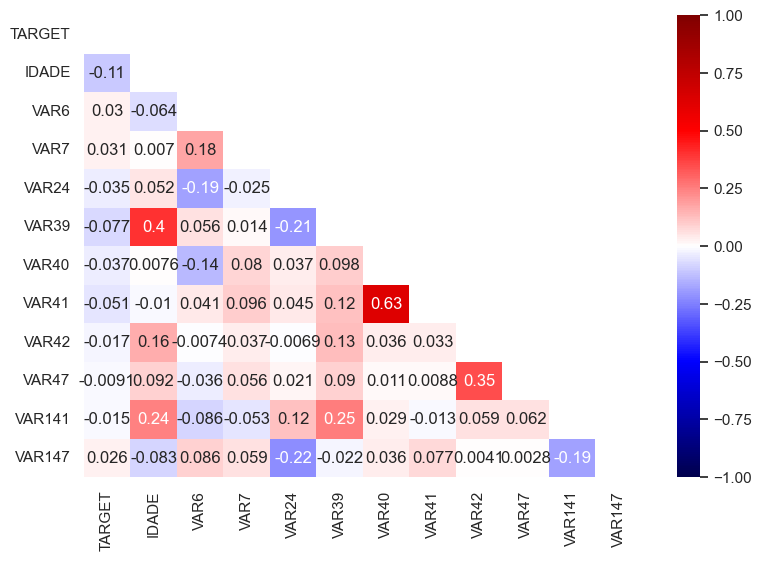

In [30]:
sns.set_theme(style="white")
cmap = 'seismic'
f, ax = plt.subplots(figsize=(9, 6))
mask = np.triu(np.ones_like(data_num.drop(columns=['ID']).corr(), dtype=bool))
vmin = -1
vmax = 1
sns.heatmap(data_num.drop(columns=['ID']).corr(), mask=mask, cmap=cmap, annot=True, vmin=vmin, vmax=vmax)

#### KDE

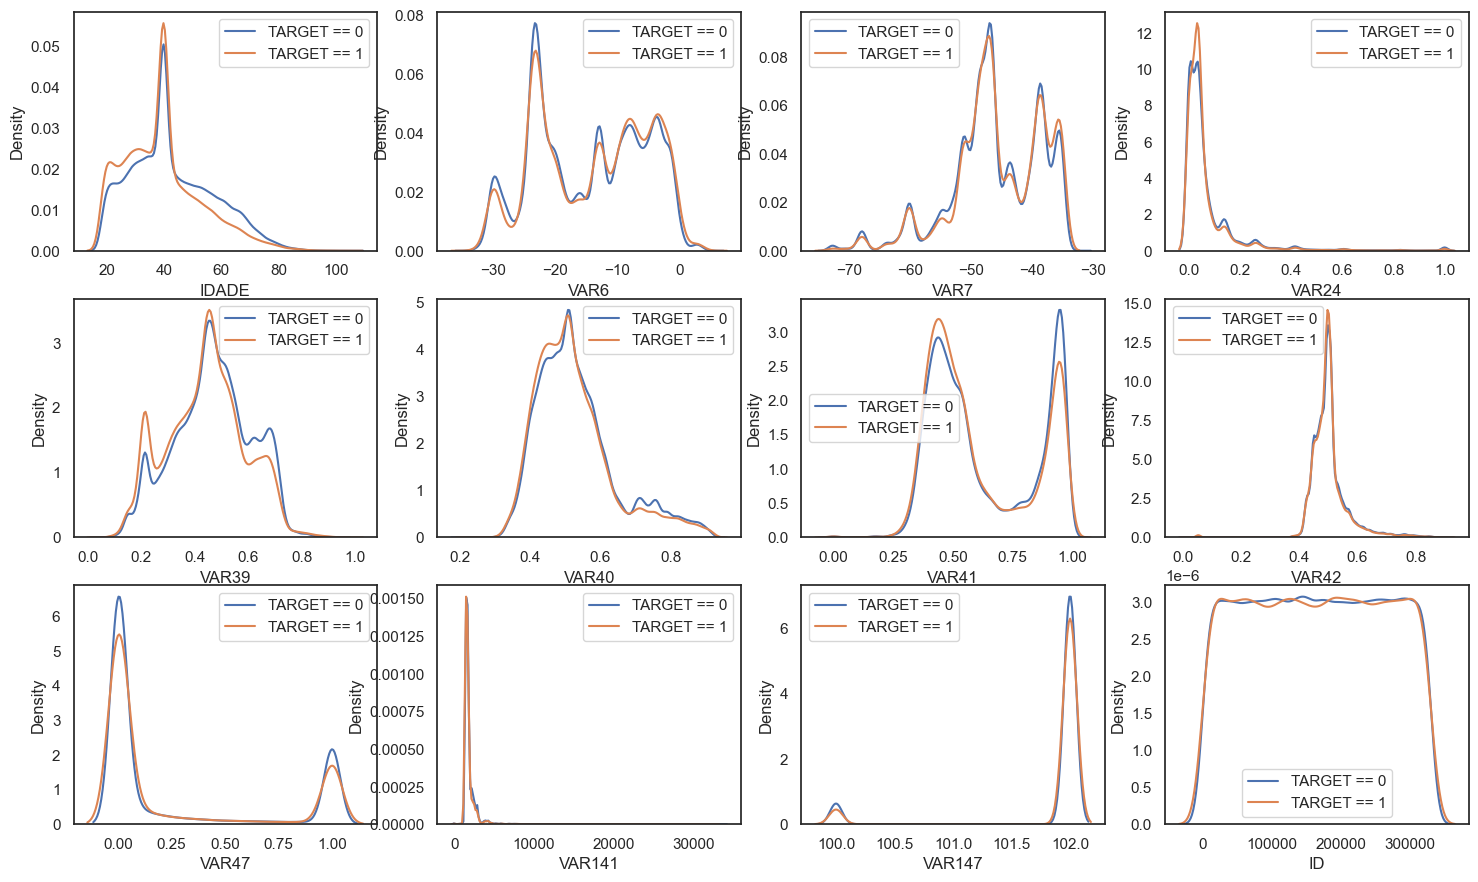

In [31]:
plt.figure(figsize = (18, 18))
data_num_0 = data_num[data_num['TARGET'] == 0].drop(columns=['TARGET'])
data_num_1 = data_num[data_num['TARGET'] == 1].drop(columns=['TARGET'])
num_columns = data_num.columns
for i in range(1, len(num_columns)):
    plt.subplot(5, 4, i)
    sns.kdeplot(data_num_0[num_columns[i]], label = 'TARGET == 0')
    sns.kdeplot(data_num_1[num_columns[i]], label = 'TARGET == 1')
    plt.legend()

### Efeito da idade no pagamento

In [32]:
def efeito_idade():
    idade_data = data_num[['TARGET', 'IDADE']].assign(IDADE_BINNED=pd.cut(data_num['IDADE'], bins=np.linspace(17, 105, num=11)))
    idade_groups  = idade_data.groupby('IDADE_BINNED').mean()

    import plotly.graph_objects as go

    fig = go.Figure(go.Bar(x=idade_groups.index.astype(str), y=100 * idade_groups['TARGET'],
                showlegend=False,
                marker=dict(color='rgba(155, 190, 250, 0.7)')
                ))
    fig.add_annotation(
        text='Pagamento por grupo de idade',
        xref='paper', yref='paper',
        x=-0.15, y=1.1,  
        showarrow=False,
        font=dict(size=12, color='rgba(100, 159, 237, 1)'))

    # Update layout
    fig.update_layout(title_text='% de Maus Pagamento',
                    plot_bgcolor='rgba(0, 0, 0, 0)',
                    yaxis_ticksuffix="%",
                    coloraxis_colorbar_ticksuffix="m",
                    yaxis_showticksuffix="all"
                    )
    fig.update_yaxes(ticks="outside", tickwidth=1, tickcolor='rgba(169, 169, 169, 1)', ticklen=10)
    fig.update_yaxes(showline=True, linewidth=1, linecolor='rgba(169, 169, 169, 1)')
    fig.update_layout(xaxis=dict(tickvals=idade_groups.index.astype(str))
                    )
    fig.layout.update({'width' : 500, 'height': 600})

    fig.show()


In [33]:
efeito_idade()

### Os jovens e os idosos devem ter acompanhamento especial! (Mas especialmente os muito idosos)

## Correlação Variáveis Categóricas x Target

In [34]:
data_cat_encoded

,VAR10,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,...,VAR142_D,VAR142_E,MONTH_April,MONTH_August,MONTH_February,MONTH_January,MONTH_July,MONTH_June,MONTH_March,MONTH_May
0,1.0,2.0,0.0,3.0,0.0,3.0,4.0,0.0,0.0,3.0,...,True,False,False,False,False,False,False,True,False,False
1,2.0,3.0,4.0,3.0,0.0,3.0,4.0,3.0,2.0,3.0,...,False,True,False,True,False,False,False,False,False,False
2,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,False,True,False,False,False,False,False,True,False,False
3,2.0,4.0,3.0,4.0,3.0,4.0,3.0,4.0,4.0,4.0,...,False,True,False,True,False,False,False,False,False,False
4,2.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51746,3.0,4.0,3.0,4.0,0.0,4.0,4.0,3.0,3.0,4.0,...,False,True,False,False,False,True,False,False,False,False
51747,4.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,...,False,True,False,False,False,False,False,True,False,False
51748,1.0,3.0,3.0,3.0,2.0,3.0,4.0,0.0,3.0,2.0,...,True,False,False,True,False,False,False,False,False,False
51749,2.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,2.0,...,False,True,False,False,False,False,False,True,False,False


In [35]:
data_num

,TARGET,IDADE,VAR6,VAR7,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR141,VAR147,ID
0,0,34.137,-8.808779,-63.878470,0.034,0.512334,0.486768,0.357526,0.538737,0.046,2680.289259,102,181755
1,0,40.447,-7.146537,-34.926080,0.017,0.328021,0.447454,0.414335,0.485512,0.099,1777.725469,102,287633
2,0,33.515,-27.900178,-53.314035,0.000,0.627262,0.730539,0.916771,0.519726,1.000,1695.494979,102,88015
3,1,25.797,-12.948874,-38.451863,0.000,0.338643,0.405233,0.408007,0.567710,0.000,1399.037809,102,122576
4,0,54.074,-30.051810,-51.213277,0.000,0.626047,0.770664,0.907036,0.538496,0.017,7868.793296,102,1272
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51746,1,39.855,-3.106358,-60.054396,0.069,0.496033,0.466042,0.374620,0.496036,0.000,1344.866459,102,92929
51747,0,22.099,-24.312468,-47.001652,0.000,0.466101,0.451845,0.828596,0.508360,0.000,1407.978124,102,6490
51748,0,59.753,-21.560366,-45.444131,0.138,0.433821,0.605530,0.596395,0.430747,0.001,2459.049077,102,41927
51749,1,20.340,-13.009675,-46.564254,0.034,0.503074,0.510118,0.542357,0.508360,0.000,1500.239438,102,101573


In [36]:
data_cat_encoded['TARGET'] = data_num['TARGET']
data_cat_encoded.corr()

,VAR10,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,...,VAR142_E,MONTH_April,MONTH_August,MONTH_February,MONTH_January,MONTH_July,MONTH_June,MONTH_March,MONTH_May,TARGET
VAR10,1.000000,-0.607116,-0.332361,-0.585947,-0.084745,-0.580663,-0.595669,-0.544044,-0.537954,-0.607405,...,-0.011059,0.000352,0.017130,-0.014099,-0.015062,0.019127,0.010773,-0.025941,0.006098,-0.035877
VAR66,-0.607116,1.000000,0.497818,0.816054,0.297884,0.892090,0.879414,0.772991,0.770593,0.904025,...,-0.015548,0.003845,-0.028492,0.011827,0.021091,-0.019144,-0.007753,0.025526,-0.004366,0.046639
VAR67,-0.332361,0.497818,1.000000,0.600657,0.293951,0.495689,0.475412,0.527687,0.529856,0.494446,...,-0.038461,0.000075,-0.007632,0.003462,0.005352,-0.011239,0.002389,0.011563,-0.003280,0.023508
VAR68,-0.585947,0.816054,0.600657,1.000000,0.421227,0.808384,0.753268,0.827446,0.821738,0.819993,...,-0.043656,0.002803,-0.028590,0.013571,0.023837,-0.025817,-0.003866,0.024888,-0.003952,0.039713
VAR69,-0.084745,0.297884,0.293951,0.421227,1.000000,0.298172,0.190722,0.501152,0.380604,0.315388,...,-0.056065,0.003664,-0.012564,0.000434,0.001764,-0.005818,0.001171,0.002876,0.009797,0.011351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MONTH_July,0.019127,-0.019144,-0.011239,-0.025817,-0.005818,-0.017951,-0.020850,-0.021397,-0.024762,-0.016481,...,-0.007919,-0.140610,-0.161774,-0.142587,-0.146887,1.000000,-0.150115,-0.155321,-0.145088,-0.050935
MONTH_June,0.010773,-0.007753,0.002389,-0.003866,0.001171,-0.008356,-0.005201,-0.007095,-0.006765,-0.008566,...,-0.003413,-0.133851,-0.153997,-0.135733,-0.139827,-0.150115,1.000000,-0.147855,-0.138114,-0.042690
MONTH_March,-0.025941,0.025526,0.011563,0.024888,0.002876,0.023258,0.019880,0.026553,0.027326,0.023247,...,-0.007117,-0.138493,-0.159338,-0.140440,-0.144676,-0.155321,-0.147855,1.000000,-0.142904,0.229493
MONTH_May,0.006098,-0.004366,-0.003280,-0.003952,0.009797,-0.007133,-0.000706,-0.003418,-0.011457,-0.005533,...,-0.009049,-0.129369,-0.148841,-0.131188,-0.135144,-0.145088,-0.138114,-0.142904,1.000000,-0.031637


In [37]:
correlations = data_cat_encoded.corr()['TARGET'].sort_values()
print('Correlações mais positivas:\n', correlations.tail(10))
print('\nCorrelações mais negativas:\n', correlations.head(10))

Correlações mais positivas:
 VAR98          0.043564
VAR92          0.044158
VAR142_E       0.045201
VAR89          0.045384
VAR74          0.045924
VAR66          0.046639
VAR84          0.047586
VAR118         0.051290
MONTH_March    0.229493
TARGET         1.000000
Name: TARGET, dtype: float64

Correlações mais negativas:
 MONTH_August     -0.052772
MONTH_July       -0.050935
VAR142_D         -0.047374
MONTH_June       -0.042690
VAR10            -0.035877
MONTH_May        -0.031637
MONTH_April      -0.030963
VAR120           -0.028498
VAR5_MG          -0.018025
MONTH_February   -0.017413
Name: TARGET, dtype: float64


### Excluindo variáveis que apresentam baixa correlação com o target

In [38]:
import plotly.graph_objects as go

fig = go.Figure(go.Histogram(x=correlations[:-2], nbinsx=100, marker=dict(color='rgba(155, 190, 250, 0.7)')))

fig.add_annotation(
    text='Categóricas x Target',
    xref='paper', yref='paper',
    x=-0.23, y=1.1,  
    showarrow=False,
    font=dict(size=12, color='rgba(100, 159, 237, 1)'))

# Update layout
fig.update_layout(title_text='CORRELAÇÕES',
                plot_bgcolor='rgba(0, 0, 0, 0)',
                yaxis_ticksuffix="%",
                coloraxis_colorbar_ticksuffix="m",
                yaxis_showticksuffix="all"
                )
fig.update_layout(
    title="Histogram",
    xaxis_title="Value",
    yaxis_title="Frequency"
)
fig.update_yaxes(ticks="outside", tickwidth=1, tickcolor='rgba(169, 169, 169, 1)', ticklen=10)
fig.update_yaxes(showline=True, linewidth=1, linecolor='rgba(169, 169, 169, 1)')

fig.layout.update({'width' : 400, 'height': 500})

fig.show()


In [39]:
# collect feature names of correlations between -0.002 and 0.002
# drop from dataset

def drop_low_target_corr(data_frame, low, high):
    correlations = data_frame.corr()['TARGET'].sort_values()
    corr_frame = correlations.to_frame()
    rows_to_drop = corr_frame[(corr_frame['TARGET'] > low) & (corr_frame['TARGET'] < high)]
    rows_to_drop.index.to_list()

    return data_frame.drop(columns=rows_to_drop)

data_cat_corr = drop_low_target_corr(data_cat_encoded, -0.002, 0.002)


## Correlação Variáveis x Variáveis

In [40]:
all_data = pd.concat([data_num, data_cat_encoded], axis=1).drop(columns=['TARGET'])
all_data.corr()

,IDADE,VAR6,VAR7,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR141,...,VAR142_D,VAR142_E,MONTH_April,MONTH_August,MONTH_February,MONTH_January,MONTH_July,MONTH_June,MONTH_March,MONTH_May
IDADE,1.000000,-0.064221,0.006996,0.052485,0.404054,0.007622,-0.009956,0.159878,0.092104,0.243246,...,0.373314,-0.390058,0.011774,0.009972,-0.016267,-0.031730,0.008954,0.000257,0.000518,0.015441
VAR6,-0.064221,1.000000,0.177161,-0.185727,0.056422,-0.137198,0.041487,-0.007383,-0.035748,-0.085721,...,-0.033909,0.057279,0.001174,-0.007055,0.001849,0.012281,-0.007914,0.005510,-0.002602,-0.002213
VAR7,0.006996,0.177161,1.000000,-0.025117,0.014193,0.080335,0.095734,0.037143,0.055708,-0.053163,...,-0.034072,0.051871,-0.003557,0.002762,-0.003775,0.001951,0.009397,-0.006386,-0.009640,0.008932
VAR24,0.052485,-0.185727,-0.025117,1.000000,-0.205543,0.036843,0.044916,-0.006858,0.020512,0.122262,...,-0.017231,-0.023972,-0.004269,0.003877,-0.001763,-0.002874,0.005007,0.001915,-0.005484,0.003084
VAR39,0.404054,0.056422,0.014193,-0.205543,1.000000,0.098010,0.119399,0.130707,0.090401,0.251693,...,0.431561,-0.449929,0.009352,0.001216,-0.011436,-0.013216,0.004807,0.004548,-0.005934,0.010642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MONTH_January,-0.031730,0.012281,0.001951,-0.002874,-0.013216,-0.020750,-0.018779,-0.014948,-0.054520,-0.031511,...,-0.025461,0.027763,-0.130974,-0.150687,-0.132815,1.000000,-0.146887,-0.139827,-0.144676,-0.135144
MONTH_July,0.008954,-0.007914,0.009397,0.005007,0.004807,0.022464,0.022785,0.007302,0.016936,0.006094,...,0.008882,-0.007919,-0.140610,-0.161774,-0.142587,-0.146887,1.000000,-0.150115,-0.155321,-0.145088
MONTH_June,0.000257,0.005510,-0.006386,0.001915,0.004548,0.001613,0.004998,0.003643,0.008871,0.002627,...,0.003303,-0.003413,-0.133851,-0.153997,-0.135733,-0.139827,-0.150115,1.000000,-0.147855,-0.138114
MONTH_March,0.000518,-0.002602,-0.009640,-0.005484,-0.005934,-0.022714,-0.023154,-0.001969,0.005652,0.011981,...,0.004909,-0.007117,-0.138493,-0.159338,-0.140440,-0.144676,-0.155321,-0.147855,1.000000,-0.142904


In [41]:
# função para remover variáveis com correlação mais que um threshold
def remove_corr_var(all_data):
    corrs = all_data.corr()
    threshold = 0.8
    above_threshold_vars = {}
    corrs = all_data.corr()
    for col in corrs:
        above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

    cols_to_remove = []
    cols_seen = []
    cols_to_remove_pair = []

    for key, value in above_threshold_vars.items():
        cols_seen.append(key)
        for x in value:
            if x == key:
                next
            else:
                # Removendo uma coluna em um par
                if x not in cols_seen:
                    cols_to_remove.append(x)
                    cols_to_remove_pair.append(key)
                
    cols_to_remove = list(set(cols_to_remove))
    print('Números de colunas para remover: ', len(cols_to_remove))
    data_corrs_removed = all_data.drop(columns = cols_to_remove)
    print('Shape do dataset depois de remover colunas: ', data_corrs_removed.shape)
    return data_corrs_removed

In [42]:
treated_data = remove_corr_var(all_data)

Number of columns to remove:  39
Training Corrs Removed Shape:  (172500, 112)


OBS.: Tendo o contexto do que cada variável representa, eu poderia usar a relação entre as variáveis para extrair colunas de maior influência no modelo, como por exemplo, criando novas variáveis que seriam o produto da interação entre duas outras variáveis.

#### Repetindo os mesmos passos para um dataset sem imputação

In [43]:
# Repetindo os steps do preprocessamento para obter um dataframe sem imputação para comparar os resultados de treino
reduced_data = drop_missing_data_columns(pd.concat([train, test], axis=0))
reduced_data = simple_imputation(reduced_data, imputation=False)

check_noisy(reduced_data)

reduced_data = reduced_data[reduced_data['VAR2'] != 'I']
reduced_data_num, reduced_data_cat = split_num_cat(reduced_data)

reduced_data_cat['MONTH'] = pd.to_datetime(reduced_data_cat['REF_DATE']).dt.strftime('%B')
reduced_data_cat.drop(columns=['REF_DATE', 'VAR148', 'VAR149'], inplace=True)

reduced_data_cat_encoded = preprocessing_cat(reduced_data_cat)

Columns with more than 20% NaN values have been removed.
Number of columns removed:  38
Shape of the dataset after dropping columns:  (172501, 113)
Shape of the dataset after removing rows with NaN values: (129606, 113)
Dados duplicados:  [False]
NaN : 0
Target unique values:  [0 1]
Unique combinations of the columns in data_noisy with distinct target values:  [1]
(0, 113)


In [44]:
reduced_data_cat_encoded['TARGET'] = reduced_data_num['TARGET']
reduced_data_cat_encoded = drop_low_target_corr(reduced_data_cat_encoded, -0.002, 0.002)

all_reduced_data = pd.concat([reduced_data_num, reduced_data_cat_encoded], axis=1).drop(columns=['TARGET'])
treated_reduced_data = remove_corr_var(all_reduced_data)

Number of columns to remove:  43
Training Corrs Removed Shape:  (129606, 108)


In [45]:
percent_good, percent_bad = percentage_target(reduced_data)
plot_class_imbalance(percent_bad, percent_good)

% Bons Pagadores:  77.51 %
% Maus Pagadores:  22.49 %


#### Separando variáveis de treino e teste, separando coluna target e dando drop na coluna ID

In [46]:
# Imputed
target = data_num['TARGET']
test_data = treated_data[treated_data["ID"].isin(test_ids)]

total_data = treated_data.drop(columns="ID")
train_data = treated_data[~treated_data['ID'].isin(test_ids)]
test_data = test_data.drop(columns="ID")

print('Total data shape: ', total_data.shape)
print('Target shape: ', target.shape)
print('Train data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)

Total data shape:  (172500, 111)
Target shape:  (172500,)
Train data shape:  (120750, 112)
Test data shape:  (51750, 111)


In [47]:
# Reduced
reduced_target = reduced_data_num['TARGET']
test_reduced_data = treated_reduced_data[treated_reduced_data["ID"].isin(test_ids)]

total_reduced_data = treated_reduced_data.drop(columns="ID")
train_reduced_data = treated_reduced_data[~treated_reduced_data['ID'].isin(test_ids)]
test_reduced_data = test_reduced_data.drop(columns="ID")

print('Total reduced_data shape: ', total_reduced_data.shape)
print('Target shape: ', target.shape)
print('Train reduced_data shape: ', train_reduced_data.shape)
print('Test reduced_data shape: ', test_reduced_data.shape)

Total reduced_data shape:  (129606, 107)
Target shape:  (129606,)
Train reduced_data shape:  (90690, 108)
Test reduced_data shape:  (38916, 107)


In [51]:
target = data_num['TARGET']
reduced_target = reduced_data_num['TARGET']

# Treinamento
Nesta sessão vou treinar uma seleção de modelos de machine learning a fim de comparar as performances.

Para cada modelo vou fazer também uma otimização de hiperparâmetros e usar k-fold cross-validation para obter uma avaliação de performance média para cada modelo.

Os modelos selecionados serão: Logistic Regression, Random Forest e Gradient Boosting (ATENÇAO OVERFITTING)

Outro variante vai ser o encoding das variáveis categóricas (Ordinal ou OHE) e a utilização das variáveis categóricas não encodificadas no modelo de Random Forest.

Outro variante será utilizar um conjunto de dados com dimensionalidade reduzida (PCA), e outro com Feature Selection.

#### Métricas de Avaliação

Como a variável de target é desbalanceada entre as classes, a acurácia não é tão indicada como métrica de avaliação. Vou usar então a métrica ROC-AUC, F1, Precision e Recall, para avaliar meus modelos.

In [48]:
# imprimindo métricas
def print_results(results, scores):
    for metric in results:
        avg = results[metric].mean()
        std = results[metric].std()
        print(metric.upper())
        print("Average: %.2f" % (avg * 100))
        print("Interval: %.2f, %.2f" % ((avg - 2*std)*100, (avg + 2*std)*100))
    

## Baselines

### Regressão Logística

In [68]:
def log_reg(X, y, pca, pca_components, minmax):
    from sklearn.model_selection import cross_val_score, train_test_split
    from sklearn.model_selection import StratifiedKFold
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.decomposition import PCA
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import GridSearchCV

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    param_grid = {'classifier__C': [0.001, 0.01, 0.1, 1]}

    if pca and not minmax:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=pca_components)),
            ('classifier', LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=42))
        ])
    elif pca and minmax:
        pipeline = Pipeline([
            ('scaler', MinMaxScaler()),
            ('pca', PCA(n_components=pca_components)),
            ('classifier', LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=42))
        ])
    else:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression())
        ])


    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    print("Best parameter (C):", grid_search.best_params_)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    test_roc_auc = roc_auc_score(y_test, y_pred)

    print("Test ROC-AUC score:", test_roc_auc)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    '''
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_test)
    test_roc_auc = roc_auc_score(y_test, y_proba[:, 1], multi_class='ovr')
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred)

    print("Cross-validation ROC-AUC scores:", cv_scores)
    print("Mean CV ROC-AUC score:", cv_scores.mean())
    print("Test ROC-AUC score:", test_roc_auc)
    print("Classification Report:\n", report)
    '''

In [52]:
log_reg(total_data, target, pca=False, pca_components = 70, minmax=False)

Best parameter (C): {'classifier__C': 0.001}
Test ROC-AUC score: 0.5430939705218785
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.96      0.85     26047
           1       0.49      0.13      0.21      8453

    accuracy                           0.75     34500
   macro avg       0.63      0.54      0.53     34500
weighted avg       0.70      0.75      0.70     34500



In [53]:
log_reg(total_data, target, pca=True, pca_components = 70, minmax=False)

Best parameter (C): {'classifier__C': 0.01}
Test ROC-AUC score: 0.6257320922537125
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76     26047
           1       0.37      0.56      0.45      8453

    accuracy                           0.66     34500
   macro avg       0.60      0.63      0.60     34500
weighted avg       0.72      0.66      0.68     34500



In [54]:
log_reg(total_reduced_data, reduced_target, pca=True, pca_components = 70, minmax=False)

Best parameter (C): {'classifier__C': 0.1}
Test ROC-AUC score: 0.6406520286392677
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.73      0.78     20091
           1       0.37      0.55      0.44      5831

    accuracy                           0.69     25922
   macro avg       0.61      0.64      0.61     25922
weighted avg       0.74      0.69      0.71     25922



In [69]:
log_reg(total_reduced_data, reduced_target, pca=True, pca_components = 70, minmax=True)

Best parameter (C): {'classifier__C': 0.1}
Test ROC-AUC score: 0.633697272505282
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.73      0.78     20091
           1       0.37      0.53      0.44      5831

    accuracy                           0.69     25922
   macro avg       0.61      0.63      0.61     25922
weighted avg       0.74      0.69      0.71     25922



## Random-forest

In [61]:
def random_forest(X, y, pca, n_estimators, score):
    from sklearn.model_selection import cross_val_score, train_test_split

    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import StratifiedKFold
    from sklearn.pipeline import Pipeline
    from sklearn.decomposition import PCA
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import GridSearchCV

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    # param_grid = {'classifier__n_estimators': [100, 200]}

    if pca==True:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=70)),
            ('classifier', RandomForestClassifier(n_estimators=n_estimators, random_state=42, class_weight='balanced'))
        ])
    #
    else:
        pipeline = Pipeline([
            ('classifier', RandomForestClassifier(n_estimators=n_estimators, random_state=42, class_weight='balanced'))
        ])
    
    '''
    grid_search = GridSearchCV(pipeline, cv=cv, scoring='roc_auc') # param_grid, scoring='roc_auc_ovr_weighted'
    grid_search.fit(X_train, y_train)
    print("Best parameter (C):", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    print("Test ROC-AUC score:", test_roc_auc)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    '''
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=score)
    pipeline.fit(X_train, y_train)

    y_proba = pipeline.predict_proba(X_test)
    test_roc_auc = roc_auc_score(y_test, y_proba[:, 1])

    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred)

    print("Cross-validation ROC-AUC scores:", cv_scores)
    print("Mean CV ROC-AUC score:", cv_scores.mean())
    print("Test ROC-AUC score:", test_roc_auc)
    print("Classification Report:\n", report)

Imputed data

In [56]:
random_forest(total_data, target, scaler=True, n_estimators=100, score='roc_auc_ovr_weighted')

Cross-validation ROC-AUC scores: [0.67483257 0.6764967  0.67217563 0.67198771 0.67762912]
Mean CV ROC-AUC score: 0.674624345046297
Test ROC-AUC score: 0.6733113798859474
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.96      0.86     26047
           1       0.49      0.11      0.18      8453

    accuracy                           0.75     34500
   macro avg       0.63      0.54      0.52     34500
weighted avg       0.70      0.75      0.69     34500



In [66]:
random_forest(total_data, target, scaler=True, n_estimators=100, score='f1')

Cross-validation ROC-AUC scores: [0.16805081 0.16660532 0.16364971 0.17311634 0.16956152]
Mean CV ROC-AUC score: 0.1681967385733249
Test ROC-AUC score: 0.6733113798859474
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.96      0.86     26047
           1       0.49      0.11      0.18      8453

    accuracy                           0.75     34500
   macro avg       0.63      0.54      0.52     34500
weighted avg       0.70      0.75      0.69     34500



In [62]:
random_forest(total_data, target, scaler=True, n_estimators=100, score='recall')

Cross-validation ROC-AUC scores: [0.09878734 0.09863946 0.09906846 0.104983   0.09788555]
Mean CV ROC-AUC score: 0.09987276140165031
Test ROC-AUC score: 0.6733113798859474
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.96      0.86     26047
           1       0.49      0.11      0.18      8453

    accuracy                           0.75     34500
   macro avg       0.63      0.54      0.52     34500
weighted avg       0.70      0.75      0.69     34500



In [58]:
random_forest(total_data, target, scaler=True, n_estimators=200, score='roc_auc_ovr_weighted')

Cross-validation ROC-AUC scores: [0.67627631 0.67259925 0.67632292 0.6842597  0.67683177]
Mean CV ROC-AUC score: 0.6772579898872207
Test ROC-AUC score: 0.6776415842229998
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.96      0.86     26047
           1       0.49      0.11      0.17      8453

    accuracy                           0.75     34500
   macro avg       0.63      0.53      0.51     34500
weighted avg       0.70      0.75      0.69     34500



Reduced data

In [57]:
random_forest(total_reduced_data, reduced_target, scaler=True, n_estimators=100, score='roc_auc_ovr_weighted')

Cross-validation ROC-AUC scores: [0.68916786 0.68342427 0.68548555 0.68598829 0.68043775]
Mean CV ROC-AUC score: 0.6849007442010768
Test ROC-AUC score: 0.6930410424371546
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.98      0.87     20091
           1       0.55      0.10      0.17      5831

    accuracy                           0.78     25922
   macro avg       0.67      0.54      0.52     25922
weighted avg       0.73      0.78      0.71     25922



In [67]:
random_forest(total_reduced_data, reduced_target, scaler=True, n_estimators=100, score='f1')

Cross-validation ROC-AUC scores: [0.14233038 0.1517341  0.14615385 0.15985401 0.15605153]
Mean CV ROC-AUC score: 0.15122477631529946
Test ROC-AUC score: 0.6930410424371546
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.98      0.87     20091
           1       0.55      0.10      0.17      5831

    accuracy                           0.78     25922
   macro avg       0.67      0.54      0.52     25922
weighted avg       0.73      0.78      0.71     25922



In [64]:
def custom_scorer(y_true, y_pred):
    from sklearn.metrics import roc_auc_score, recall_score

    roc_auc = roc_auc_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    # Combine the two metrics into a single score (e.g., average, weighted sum, etc.)
    combined_score = (roc_auc + recall) / 2
    return combined_score

In [65]:
from sklearn.metrics import make_scorer
custom_scorer = make_scorer(custom_scorer)
random_forest(total_reduced_data, reduced_target, scaler=True, n_estimators=100, score=custom_scorer)

Cross-validation ROC-AUC scores: [0.30934591 0.30368634 0.30906545 0.31442444 0.30513848]
Mean CV ROC-AUC score: 0.30833212421446676
Test ROC-AUC score: 0.6930410424371546
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.98      0.87     20091
           1       0.55      0.10      0.17      5831

    accuracy                           0.78     25922
   macro avg       0.67      0.54      0.52     25922
weighted avg       0.73      0.78      0.71     25922



## Gradient Boosting

In [ ]:
def gradient_boosting(X, y):
    from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_auc_score
    from sklearn.utils import class_weight

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    gb_clf = GradientBoostingClassifier()
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('gb_clf', gb_clf)
        ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_roc_auc = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')

    pipeline.fit(X_train, y_train, gb_clf__sample_weight=class_weights[y_train])

    y_pred_proba = gb_clf.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)

    y_pred = gb_clf.predict(X_test)
    classification_rep = classification_report(y_test, y_pred)

    print("Cross-Validation ROC AUC Scores:", cv_roc_auc)
    print("Mean Cross-Validation ROC AUC:", np.mean(cv_roc_auc))
    print("Test ROC AUC:", test_roc_auc)
    print("Classification Report on Testing Set:")
    print(classification_rep)    

In [ ]:
gradient_boosting(total_data, target)

# Análise financeira

# Escoragem da base Out-of-time

In [ ]:
oot_data = pd.read_csv('oot.gz', compression='gzip')
print("Formato dataset: ", oot_data.shape)
oot_data.head(5)

In [ ]:
def predict_oot(best_model, oot_data):

    from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

    features = total_data.columns
    X_oot = oot_data[features]

    # Assuming 'target' is your target variable
    # Select the target variable from the OOT dataset
    y_oot = oot_data['target']

    # Probabilidades da classe positiva
    y_pred_proba_oot = best_model.predict_proba(X_oot)[:, 1]
    # ROC AUC score
    roc_auc_oot = roc_auc_score(y_oot, y_pred_proba_oot)
    print("ROC AUC on the OOT dataset:", roc_auc_oot)

    
    y_pred_oot = best_model.predict(X_oot)
    # F1 score
    f1_oot = f1_score(y_oot, y_pred_oot)
    print("F1 score on the OOT dataset:", f1_oot)
    # Precision
    precision_oot = precision_score(y_oot, y_pred_oot)
    print("Precision on the OOT dataset:", precision_oot)
    # Recall
    recall_oot = recall_score(y_oot, y_pred_oot)
    print("Recall on the OOT dataset:", recall_oot)